The dataset Spam Email Classification Dataset was found on Kaggle at:
https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset/data
The dataset was uploaded from Puru Singhvi and uses these sources: 2007 TREC Public Spam Corpus and Enron-Spam Dataset

Goal and questions to answer: 
 * From a dataset with spam classifications and email text, use logistic regression to accurately predict whether an email is spam.
     - What key words are associated with spam?
     - What kind of accuracy can be expected from this method? 

The dataset was modified to reduce the size, specifically, special characters were removed, spam to ham ratio was adjusted to match current ratios in todays envirionment. Rows were droped in a manner that preserved database balance, and the file was compressed. This resulted in significant cleaning steps before even uploading the dataset, reducing it's size from 130 MB to 18 MB. See data_preprocessing.ipynb for data cleaning and pre-processing.

The dataset is has two columns: label and text

label: classification -> target

* '1' indicates that the email is classified as spam.
* '0' denotes that the email is legitimate (ham).

text: -> predictor

* full email string

In [11]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset into a Pandas dataframe and perform a basic review to identify contents and balance.

In [13]:
spam = pd.read_csv('spam5.csv.gz')
display(spam)

,label,text
0,1,of free play time what children plenty of time...
1,1,princeton tech newsletter the new entertainmen...
2,1,hello cbs a mythicize p news a r overman ecord...
3,0,hi on freebsd setgroups behaves a bit non stan...
4,0,i m trying to install spreadsheet parseexcel e...
...,...,...
39990,0,attached are the re start plans for the gas fu...
39991,0,on sat escapenumber escapenumber escapenumber ...
39992,1,dear customer this is the letter from the cana...
39993,1,dear customer wanna know how to save much on y...


In [15]:
print(spam.describe())

              label
count  39995.000000
mean       0.448956
std        0.497394
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


<Axes: xlabel='label'>

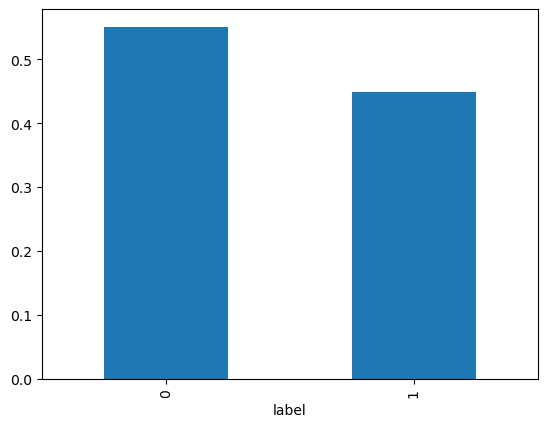

In [17]:
spam['label'].value_counts(normalize = True).plot.bar()

#### Split testing and training datasets using sklearn's train_test_split using an 80/20 split. More info about train_test_split can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [19]:
X_train, X_test, y_train, y_test = train_test_split(spam['text'], spam['label'], test_size=0.2, random_state=5)

#### Next, a "bag of words" will be created to use in the model. The words will be used to classify emails into spam or ham. The first 20 are printed to get a feel for what words are common and ensure the "bag of words" is working as intended. This results in a large list and will need to be reduced.

In [21]:
list_of_word_lists = X_train.str.split().explode().tolist()
print(list_of_word_lists[0:50])
print(len(list_of_word_lists))

['on', 'wednesday', 'escapenumber', 'april', 'escapenumber', 'escapenumber', 'escapenumber', 'alek', 'storm', 'wrote', 'on', 'escapenumber', 'escapenumber', 'escapenumber', 'allison', 'randal', 'wrote', 'actually', 'setting', 'vtable', 'without', 'setting', 'method', 'makes', 'a', 'great', 'deal', 'of', 'sense', 'if', 'you', 'want', 'to', 'override', 'a', 'low', 'level', 'vtable', 'operation', 'without', 'adding', 'a', 'named', 'method', 'to', 'the', 'class', 'just', 'use', 'the']
8377126


#### The words then are temporary converted to a set to remove duplicates and only maintain words that have more than 100 occurances, more than 2 characters, and are not digits. Then, thay are recoverted to list for the next step.

In [23]:
counts = Counter(list_of_word_lists)
filtered_set = {
    w
    for w in list_of_word_lists
    if counts[w] > 100 and len(w) > 2 and not w.isdigit()
}
filtered_list = list(filtered_set)
print(len(filtered_list))
print(filtered_list[0:20])

6035
['styescapenumber', 'cvs', 'para', 'audience', 'removed', 'latest', 'apply', 'continued', 'errstr', 'interfaces', 'float', 'covered', 'capacity', 'phone', 'managing', 'clicking', 'mkt', 'humidex', 'token', 'little']


#### This number is a good balance. A tool called TfidVecotorizer will be used to add weight to each word. The vetorizer creates a sparse matrix with associated with words and positions in each row. More information can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [24]:
vectorizer = TfidfVectorizer(vocabulary=filtered_list)
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.fit_transform(X_test)

#### The logistic model will be trained using the 'liblinear' solver which works well with sparse matricies and small to medium size datasets. Class weights will also be included which penalize mislabing Ham over Spam. For more info see:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [27]:
model = LogisticRegression(solver='liblinear', max_iter=2000, class_weight={0: 2, 1: 1})
model.fit(X_train_v, y_train)

LogisticRegression(class_weight={0: 2, 1: 1}, max_iter=2000, solver='liblinear')

#### One of the goals was to see which words are more closely associated with spam. The names and weights will be extracted and plotted to see the 30 words with the highest assigned weight.

In [29]:
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0]
word_weights = pd.DataFrame({
    'word': feature_names,
    'weight': coef,
})

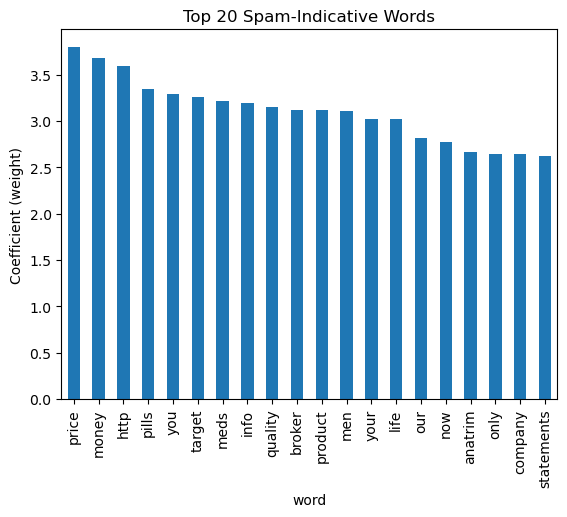

In [39]:
top_spam_words = word_weights.sort_values(by='weight', ascending=False).head(20)
top_spam_words.plot.bar(x='word', y='weight', legend=False)
plt.title("Top 20 Spam-Indicative Words")
plt.ylabel("Coefficient (weight)")
plt.show()

#### Below is a function to build confusion matrixies. This will show how well model preforms on our data.

In [41]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_total = cm.sum()
    
    cm_labels = np.array([["{} ({:.1f}%)".format(val, val/cm_total*100) for val in row] for row in cm])
    
    color_matrix = cm.astype(float)
    color_matrix = color_matrix / color_matrix.max()
    
    mask = np.eye(*cm.shape, dtype=bool) 
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=cm_labels, fmt='', cmap="viridis", xticklabels=labels, yticklabels=labels,
                cbar=True, linewidths=0.5, linecolor='gray', square=True)
    
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

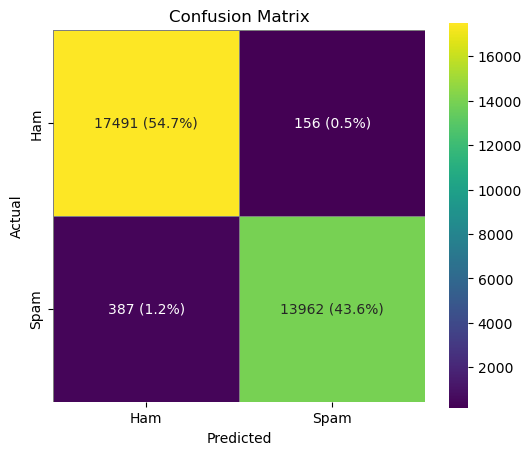

In [43]:
y_train_pred = model.predict(X_train_v)
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_train, y_train_pred, ['Ham', 'Spam'])

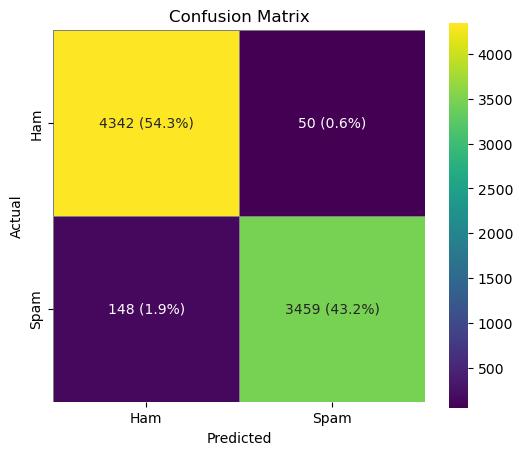

In [45]:
y_test_pred = model.predict(X_test_v)
cm_test = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(y_test, y_test_pred, ['Ham', 'Spam'])

In [47]:
acc = (cm_train[0][0] + cm_train[1][1])/np.sum(cm_train)
print(acc)

acc = (cm_test[0][0] + cm_test[1][1])/np.sum(cm_test)
print(acc)

0.9830291286410802
0.9752469058632329


#### Conclusion: Even with the reduced dataset size the accuracy of both the training and testing set was about 98%. This shows that detecting spam with a high level of accuracy is possible. 